![Banner](./img/AI_Special_Program_Banner.jpg)

# Sample solution for association analysis
---

<h2 style="color:blue">Task 1 - Theory</h2>

---

Take a look at the [Documentation on association rules in `Mlxtend`](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) and answer the following questions:

<h4 style="color:blue"> 1.1 How is the <em>leverage</em> metric calculated? </h4>
The `leverage` metric is calculated as the difference between the relative frequency for X and Y together (i.e. the *support*) and the relative frequency that would be expected if both item(set)s were independent of each other. The corresponding formula is

$$
\text{lev}(X\rightarrow Y) = \text{sup}(X\rightarrow Y) - \text{sup}(X)\times\text{sup}(Y)\>.
$$

Obviously, this is again symmetrical in X and Y, i.e.

$$
\text{lev}(X\rightarrow Y) = \text{lev}(Y\rightarrow X)\>.
$$

<h4 style="color:blue"> 1.2 How is the <em>conviction</em> metric calculated? </h4>

The `conviction` metric is the quotient of the difference of 1 to the expected confidence of Y and the difference of 1 to the actual confidence of Y given X (or, expressed in probabilities, the quotient of the counter-probability for Y and the (conditional) counter-probability for Y under the condition X). The formula is

$$
\text{conv}(X\rightarrow Y) = \frac{1-\text{sup}(Y)}{1-\text{conf}(X\rightarrow Y)}
$$

Here it makes a difference whether you assume X or Y as given, so that the values for the `conviction` for $X\rightarrow Y$ and $Y\rightarrow X$ generally differ.

<h2 style="color:blue"> Task 2 - Analysis of Steam user statistics with Python </h2>

---

In this task, you are to carry out an association analysis with a data set that does not contain data on sales, but on user statistics. However, as no metrics are analyzed for the individual transactions, the similarity to pure sales data is very high. However, it should be noted that association analysis can also make sense if the data is not about transactions from sales, even if the entire terminology was derived from this area.

In particular, you are to analyze the user statistics of users of the video game distribution platform [Steam](https://store.steampowered.com/about/). Proceed as follows:

<h4 style="color:blue">2.1 Perform an association analysis of Steam user statistics <b>analogous to the example presented</b></h4>

We use a dataset that is an adaptation of the collected Steam data from [Apurva Pathak et al. 2017](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir17.pdf). More specifically, it is the user statistics of 4311 Australian users of the video game distribution platform *Steam*. The version used here is only an excerpt of the original data and only contains games that were played for more than 30 hours.

The data set is located in the subfolder [data](data/steam_users.txt).

The aim is to find rules with
* `support` of at least 1% and
* `confidence` of at least 50%

In [1]:
import csv
import pandas as pd
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

Read in the data record:

In [2]:
with open('data/steam_users.txt', 'r') as f:
    reader = csv.reader(f)
    sd = list(reader)
sd[:3]

[['Day of Defeat Source',
  'CounterStrike Source',
  'Deus Ex Game of the Year Edition',
  'Killing Floor',
  'Plants vs Zombies Game of the Year',
  'Borderlands',
  'Call of Duty Modern Warfare 2',
  'Dragon Age Origins',
  'Mass Effect 2',
  'Battlefield Bad Company 2',
  'Just Cause 2',
  'Sid Meiers Civilization V',
  'Call of Duty Black Ops  Multiplayer',
  'Warhammer 40000 Dawn of War II',
  'Rising StormRed Orchestra 2 Multiplayer',
  'The Elder Scrolls V Skyrim',
  'Tropico 4',
  'Dead Island',
  'CounterStrike Global Offensive',
  'BioShock Infinite',
  'XCOM Enemy Unknown',
  'FINAL FANTASY VII',
  'Deus Ex Human Revolution  Directors Cut',
  'Insurgency',
  'Dirty Bomb',
  'Killing Floor 2',
  'Fallout 4'],
 ['Portal 2',
  'Terraria',
  'Deus Ex Human Revolution',
  'Saints Row The Third',
  'The Elder Scrolls V Skyrim',
  'Saints Row IV',
  'Tropico 4',
  'Assassins Creed IV Black Flag',
  'Deus Ex Human Revolution  Directors Cut',
  'Assassins Creed Unity',
  'Batman Ark

The necessary data preparation incl. One-Hot_Encoding:

In [3]:
oht = TransactionEncoder()
oht_ary = oht.fit(sd).transform(sd)
sddf = pd.DataFrame(oht_ary, columns=oht.columns_)

In [4]:
sddf.head()

,Knights II,Delicious,Inc,Serve,Vikings,100% Orange Juice,1001 Spikes,16bit Trader,1701 AD Gold Edition,3DMark,...,Ys Origin,Zombie Army Trilogy,Zombie Driver HD,Zombies Monsters Robots,how do you Do It?,liteCam Game 100 FPS Game Capture,rFactor 2,resident evil 4 biohazard 4,theHunter,侠客风云传Tale of Wuxia
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Preliminary considerations

First examine the sparseness again:

In [5]:
nsddf = sddf.shape[0]
nsddf

4311

In [6]:
nitems = sddf.shape[1]
nitems

1744

In [7]:
nnz = np.count_nonzero(sddf)
nnz

50440

In [8]:
sparsity = 100 * nnz / (nsddf*nitems)
print("The featurea matrix has  ~{0:.2f}% not null entries".format(sparsity))

The featurea matrix has  ~0.67% not null entries


Now get an impression of the frequencies:

In [9]:
supplist = sddf.sum().sort_values(ascending=False)/nsddf
supplist.head()

CounterStrike Global Offensive    0.542566
Garrys Mod                        0.480399
Terraria                          0.348411
The Elder Scrolls V Skyrim        0.296915
PAYDAY 2                          0.277894
dtype: float64

In [10]:
supplist[supplist>=0.1]

CounterStrike Global Offensive    0.542566
Garrys Mod                        0.480399
Terraria                          0.348411
The Elder Scrolls V Skyrim        0.296915
PAYDAY 2                          0.277894
                                    ...   
PlanetSide 2                      0.108328
Rocket League                     0.107632
War Thunder                       0.105312
CounterStrike Source              0.104616
DayZ                              0.103224
Length: 21, dtype: float64

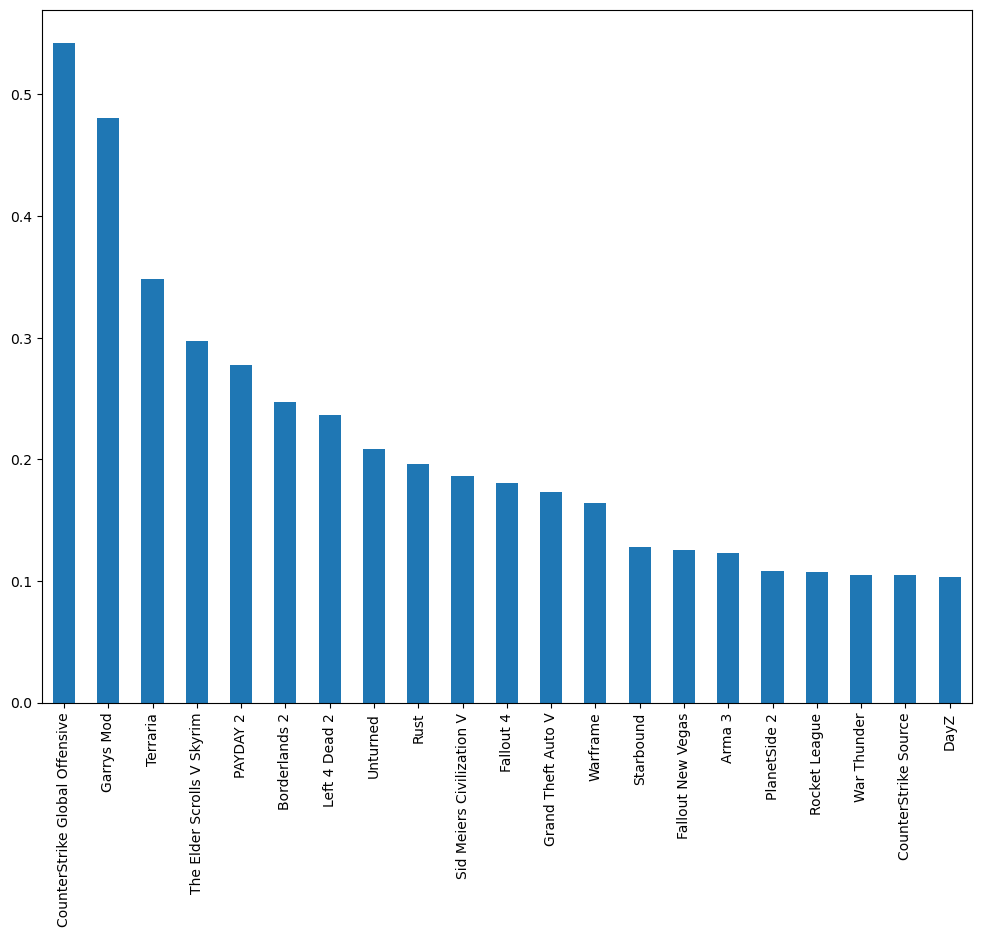

In [11]:
supplist[supplist>=0.1].plot(kind='bar', rot=90, figsize=(12,9))
plt.show()

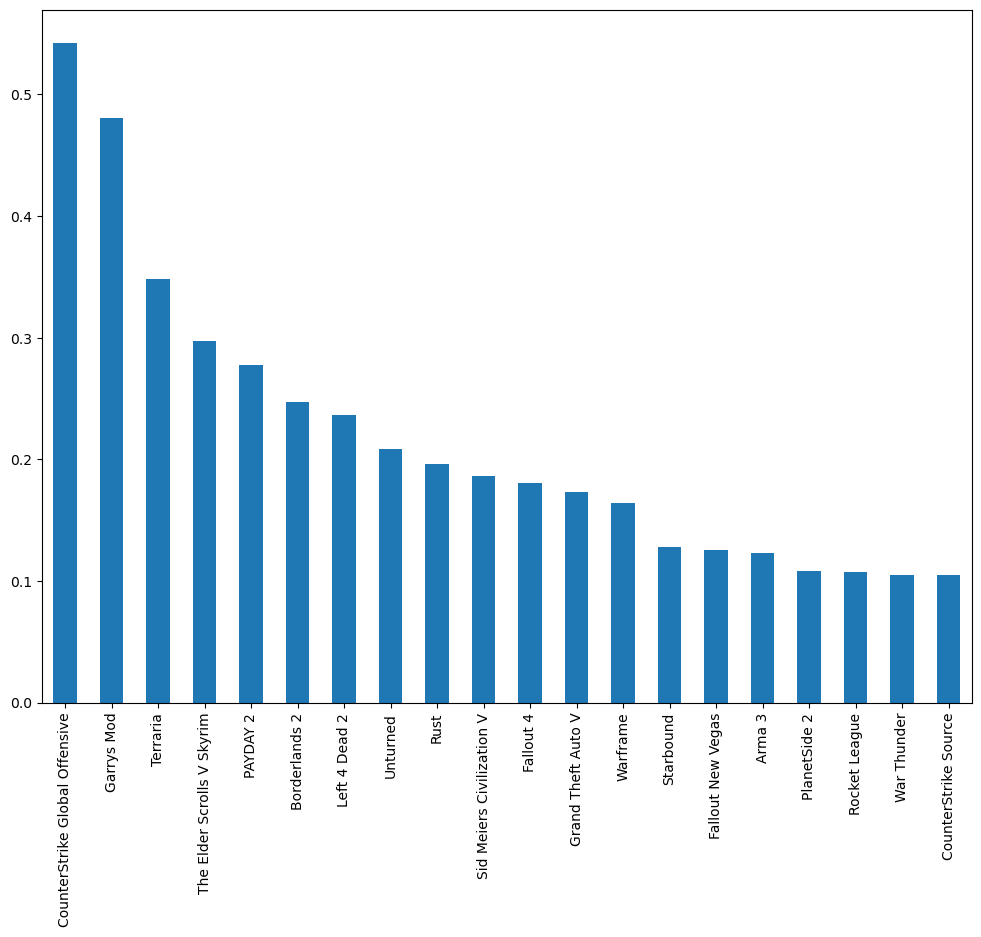

In [12]:
supplist.head(20).plot(kind='bar', rot=90, figsize=(12,9))
plt.show()

## Determining the rules

This is done again with the [a-priori algorithm of `Mlxtend`](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) and the specified parameters.

In [13]:
frequent_itemsets = apriori(sddf, min_support=0.01, max_len=10, use_colnames=True)

In [14]:
frequent_itemsets.shape

(5137, 2)

In [15]:
frequent_itemsets[50:60]

,support,itemsets
50,0.045465,(DARK SOULS III)
51,0.012990,(DRAGON BALL XENOVERSE)
52,0.048713,(Dark Souls Prepare to Die Edition)
53,0.011830,(Darkest Dungeon)
54,0.010438,(Day of Defeat Source)
55,0.103224,(DayZ)
56,0.046857,(Dead Island)
57,0.010902,(Dead Island Riptide)
58,0.013686,(Dead by Daylight)
59,0.016006,(Defiance)


In [16]:
max(frequent_itemsets.itemsets.apply(lambda x:len(x)))

6

In [17]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(7 Days to Die),(Terraria),0.031315,0.348411,0.018789,0.600000,1.722104,0.007879,1.628972,0.432870
1,(APB Reloaded),(CounterStrike Global Offensive),0.022037,0.542566,0.015542,0.705263,1.299867,0.003585,1.552010,0.235889
2,(APB Reloaded),(Garrys Mod),0.022037,0.480399,0.013454,0.610526,1.270873,0.002868,1.334111,0.217942
3,(APB Reloaded),(PAYDAY 2),0.022037,0.277894,0.012062,0.547368,1.969704,0.005938,1.595351,0.503403
4,(ARK Survival Evolved),(CounterStrike Global Offensive),0.093482,0.542566,0.053816,0.575682,1.061038,0.003096,1.078047,0.063458


In [18]:
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6488 entries, 0 to 6487
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         6488 non-null   object 
 1   consequents         6488 non-null   object 
 2   antecedent support  6488 non-null   float64
 3   consequent support  6488 non-null   float64
 4   support             6488 non-null   float64
 5   confidence          6488 non-null   float64
 6   lift                6488 non-null   float64
 7   leverage            6488 non-null   float64
 8   conviction          6488 non-null   float64
 9   zhangs_metric       6488 non-null   float64
dtypes: float64(8), object(2)
memory usage: 507.0+ KB


So 6488 rules are found here.

We also add the *absolute frequency* again.

In [19]:
rules["count"] = rules.support.apply(lambda x: int(x*nsddf+0.2))
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,count
0,(7 Days to Die),(Terraria),0.031315,0.348411,0.018789,0.600000,1.722104,0.007879,1.628972,0.432870,81
1,(APB Reloaded),(CounterStrike Global Offensive),0.022037,0.542566,0.015542,0.705263,1.299867,0.003585,1.552010,0.235889,67
2,(APB Reloaded),(Garrys Mod),0.022037,0.480399,0.013454,0.610526,1.270873,0.002868,1.334111,0.217942,58
3,(APB Reloaded),(PAYDAY 2),0.022037,0.277894,0.012062,0.547368,1.969704,0.005938,1.595351,0.503403,52
4,(ARK Survival Evolved),(CounterStrike Global Offensive),0.093482,0.542566,0.053816,0.575682,1.061038,0.003096,1.078047,0.063458,232


Now let's look again at the rules with the highest lift:

In [20]:
rules.sort_values("lift", ascending=False)[:5]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,count
146,(Crusader Kings II),(Europa Universalis IV),0.019717,0.025052,0.010438,0.529412,21.132353,0.009944,2.071764,0.971841,45
72,(Call of Duty Modern Warfare 3),(Call of Duty Modern Warfare 3 Multiplayer),0.016469,0.035955,0.012062,0.732394,20.370014,0.011470,3.602486,0.966831,52
58,(Call of Duty Black Ops),(Call of Duty Black Ops Multiplayer),0.025980,0.035955,0.015774,0.607143,16.886406,0.014840,2.453934,0.965874,68
333,(Total War ATTILA),(Total War ROME II Emperor Edition),0.017861,0.052424,0.015078,0.844156,16.102459,0.014141,6.080279,0.954954,65
70,(Call of Duty Modern Warfare 2),(Call of Duty Modern Warfare 2 Multiplayer),0.016006,0.043609,0.011134,0.695652,15.951896,0.010436,3.142426,0.952558,48


<h4 style="color:blue"> 2.2 Which games would you recommend to owners of the factory simulation <em>Factorio</em>? </h4>

The recommendation rules for *Factorio* are obtained with :

In [21]:
rules[rules.antecedents.apply(lambda x: x.issuperset({'Factorio'}))]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,count
192,(Factorio),(Sid Meiers Civilization V),0.019485,0.186732,0.010206,0.523810,2.805146,0.006568,1.707864,0.65630,44
193,(Factorio),(Terraria),0.019485,0.348411,0.012062,0.619048,1.776774,0.005273,1.710421,0.44587,52


<h4 style="color:blue"> 2.3 And which games are interesting for owners of the indie game <em>The Binding of Isaac</em>? </h4>

Also the rules for *The Binding of Isaac*:

In [22]:
rules[rules.antecedents.apply(lambda x: x.issuperset({'The Binding of Isaac'}))]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,count
250,(The Binding of Isaac),(Garrys Mod),0.047553,0.480399,0.024124,0.507317,1.056033,0.001280,1.054636,0.055709,104
318,(The Binding of Isaac),(Terraria),0.047553,0.348411,0.030387,0.639024,1.834111,0.013819,1.805078,0.477482,131
322,(The Binding of Isaac),(The Binding of Isaac Rebirth),0.047553,0.075389,0.028764,0.604878,8.023475,0.025179,2.340066,0.919070,124
680,"(CounterStrike Global Offensive, The Binding o...",(Borderlands 2),0.020645,0.247506,0.010902,0.528090,2.133642,0.005793,1.594570,0.542518,47
822,"(Borderlands 2, The Binding of Isaac)",(Garrys Mod),0.022501,0.480399,0.013686,0.608247,1.266130,0.002877,1.326350,0.215030,59
...,...,...,...,...,...,...,...,...,...,...,...
5067,"(Terraria, Garrys Mod, The Binding of Isaac)",(The Binding of Isaac Rebirth),0.017397,0.075389,0.010670,0.613333,8.135631,0.009359,2.391237,0.892613,46
5068,"(The Binding of Isaac Rebirth, Garrys Mod, The...",(Terraria),0.014846,0.348411,0.010670,0.718750,2.062937,0.005498,2.316761,0.523019,46
5248,"(The Elder Scrolls V Skyrim, Terraria, The Bin...",(The Binding of Isaac Rebirth),0.015774,0.075389,0.010438,0.661765,8.778054,0.009249,2.733634,0.900280,45
5249,"(The Elder Scrolls V Skyrim, The Binding of Is...",(Terraria),0.014382,0.348411,0.010438,0.725806,2.083190,0.005428,2.376383,0.527554,45


***Unfortunately*** this is not quite correct, because rules where 'The Binding of Isaac' occurs as a consequence are not taken into account. We can fix this by extending the DataFrame (see below).

But first let's look at the rules with substitution effect:

In [23]:
substrules = rules[rules.lift<1.0].sort_values(by="lift")
substrules[:5]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,count
1110,"(Left 4 Dead 2, Dead Island)",(CounterStrike Global Offensive),0.025052,0.542566,0.012526,0.5,0.921548,-0.001066,0.914869,-0.080306,54
1162,"(The Witcher 3 Wild Hunt, Fallout 4)",(CounterStrike Global Offensive),0.027836,0.542566,0.013918,0.5,0.921548,-0.001185,0.914869,-0.080518,60
4351,"(The Elder Scrolls V Skyrim, Terraria, Portal 2)",(CounterStrike Global Offensive),0.022269,0.542566,0.011134,0.5,0.921548,-0.000948,0.914869,-0.080096,48
3815,"(PAYDAY 2, Fallout 4, Sid Meiers Civilization V)",(CounterStrike Global Offensive),0.029691,0.542566,0.014846,0.5,0.921548,-0.001264,0.914869,-0.080659,64
4390,"(Terraria, XCOM Enemy Unknown, Sid Meiers Civi...",(CounterStrike Global Offensive),0.020413,0.542566,0.010206,0.5,0.921548,-0.000869,0.914869,-0.079956,44


Which games appear on the right-hand side of the substitutive rules (i.e. as a *consequence*)?

In [24]:
substrules.consequents.unique()

array([frozenset({'CounterStrike Global Offensive'})], dtype=object)

**Interpretation**: Interestingly enough, *Counter Strike Global Offensive* is the result of **all** rules without exception where there is a substitution effect. If you take a closer look at the antecedents, you will notice that these are not really shooters. The term *substitution effect* should therefore be interpreted somewhat differently here than in the case of food, for example. There, substitution means that one item is replaced by another (of the same type). With games, on the other hand, it is more the case that similar games are played more often "as well as" (just as one has a taste in books or movies). In such contexts, a substitution effect points to games (books/movies) of a *different kind*.

## Create items column
As we have seen, we can currently only consider rules in which terms occur *either* in the antecedent *or* in the consequence, as we cannot access the entirety of the items on the left and right sides of the rules at the same time. However, we would need this if we wanted to determine the corresponding rules. To do this, we add another column called `items` to our dataframe with the rules.

In [25]:
def item_extract(myfset):
    myitems = list()
    for it in myfset:
        myitems.append(it)
    return myitems

In [26]:
lista = rules.antecedents.apply(lambda x: item_extract(x))
listc = rules.consequents.apply(lambda x: item_extract(x))
rules["items"] = lista + listc
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,count,items
0,(7 Days to Die),(Terraria),0.031315,0.348411,0.018789,0.600000,1.722104,0.007879,1.628972,0.432870,81,"[7 Days to Die, Terraria]"
1,(APB Reloaded),(CounterStrike Global Offensive),0.022037,0.542566,0.015542,0.705263,1.299867,0.003585,1.552010,0.235889,67,"[APB Reloaded, CounterStrike Global Offensive]"
2,(APB Reloaded),(Garrys Mod),0.022037,0.480399,0.013454,0.610526,1.270873,0.002868,1.334111,0.217942,58,"[APB Reloaded, Garrys Mod]"
3,(APB Reloaded),(PAYDAY 2),0.022037,0.277894,0.012062,0.547368,1.969704,0.005938,1.595351,0.503403,52,"[APB Reloaded, PAYDAY 2]"
4,(ARK Survival Evolved),(CounterStrike Global Offensive),0.093482,0.542566,0.053816,0.575682,1.061038,0.003096,1.078047,0.063458,232,"[ARK Survival Evolved, CounterStrike Global Of..."


We are now in a position to set up all rules in which a term appears in the antecedent *and* in the consequence.

In [27]:
rules[rules["items"].apply(lambda x: 'Factorio' in x)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,count,items
192,(Factorio),(Sid Meiers Civilization V),0.019485,0.186732,0.010206,0.523810,2.805146,0.006568,1.707864,0.65630,44,"[Factorio, Sid Meiers Civilization V]"
193,(Factorio),(Terraria),0.019485,0.348411,0.012062,0.619048,1.776774,0.005273,1.710421,0.44587,52,"[Factorio, Terraria]"


This makes no difference to the rules with Factorio, but it does make a difference to the rules for Binding of Isaac:

In [28]:
rules[rules["items"].apply(lambda x: 'The Binding of Isaac' in x)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,count,items
250,(The Binding of Isaac),(Garrys Mod),0.047553,0.480399,0.024124,0.507317,1.056033,0.001280,1.054636,0.055709,104,"[The Binding of Isaac, Garrys Mod]"
318,(The Binding of Isaac),(Terraria),0.047553,0.348411,0.030387,0.639024,1.834111,0.013819,1.805078,0.477482,131,"[The Binding of Isaac, Terraria]"
322,(The Binding of Isaac),(The Binding of Isaac Rebirth),0.047553,0.075389,0.028764,0.604878,8.023475,0.025179,2.340066,0.919070,124,"[The Binding of Isaac, The Binding of Isaac Re..."
680,"(CounterStrike Global Offensive, The Binding o...",(Borderlands 2),0.020645,0.247506,0.010902,0.528090,2.133642,0.005793,1.594570,0.542518,47,"[CounterStrike Global Offensive, The Binding o..."
822,"(Borderlands 2, The Binding of Isaac)",(Garrys Mod),0.022501,0.480399,0.013686,0.608247,1.266130,0.002877,1.326350,0.215030,59,"[Borderlands 2, The Binding of Isaac, Garrys Mod]"
...,...,...,...,...,...,...,...,...,...,...,...,...
5068,"(The Binding of Isaac Rebirth, Garrys Mod, The...",(Terraria),0.014846,0.348411,0.010670,0.718750,2.062937,0.005498,2.316761,0.523019,46,"[The Binding of Isaac Rebirth, Garrys Mod, The..."
5247,"(The Elder Scrolls V Skyrim, Terraria, The Bin...",(The Binding of Isaac),0.020413,0.047553,0.010438,0.511364,10.753603,0.009468,1.949194,0.925908,45,"[The Elder Scrolls V Skyrim, Terraria, The Bin..."
5248,"(The Elder Scrolls V Skyrim, Terraria, The Bin...",(The Binding of Isaac Rebirth),0.015774,0.075389,0.010438,0.661765,8.778054,0.009249,2.733634,0.900280,45,"[The Elder Scrolls V Skyrim, Terraria, The Bin..."
5249,"(The Elder Scrolls V Skyrim, The Binding of Is...",(Terraria),0.014382,0.348411,0.010438,0.725806,2.083190,0.005428,2.376383,0.527554,45,"[The Elder Scrolls V Skyrim, The Binding of Is..."


This gives us 3 new rules that were not previously displayed.